In [1]:
from profiler.core import *

## 0. Load Model

In [2]:
from pgmpy.readwrite import BIFReader
reader = BIFReader("data/alarm.bif")
model = reader.get_model()
from pgmpy.sampling import BayesianModelSampling
inference = BayesianModelSampling(model)
data = inference.forward_sample(size=100000, return_type='dataframe')

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [3]:
pf = Profiler(workers=2, tol=0, eps=0.05, embedtxt=False)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [4]:
pf.session.load_data(name='hospital', src=DF, df=data, check_param=True)

INFO:profiler.utility:[0.00722813606262207] Load Data start

INFO:profiler.dataset:parameters used for data loading:
 {'na_values': {'', 'nan', 'NaN', 'none', 'unknown', '?', 'None'}, 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.dataset:inferred types of attributes: {
    "MINVOLSET": "numeric",
    "VENTMACH": "numeric",
    "DISCONNECT": "numeric",
    "VENTTUBE": "numeric",
    "INTUBATION": "numeric",
    "PULMEMBOLUS": "numeric",
    "SHUNT": "numeric",
    "PAP": "numeric",
    "FIO2": "numeric",
    "KINKEDTUBE": "numeric",
    "PRESS": "numeric",
    "VENTLUNG": "numeric",
    "MINVOL": "numeric",
    "VENTALV": "numeric",
    "PVSAT": "numeric",
    "SAO2": "numeric",
    "ARTCO2": "numeric",
    "EXPCO2": "numeric",
    "ANAPHYLAXIS": "numeric",
    "TPR": "numeric",
    "INSUFFANESTH": "numeric",
    "CATECHOL": "numeric",
    "HR": "numeric",
    "ERRCAUTER": "numer

## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [5]:
pf.session.load_training_data(difference=False)

INFO:profiler.utility:[0.08428597450256348] Create Training Data start

INFO:profiler.utility:[0.11032700538635254] Create Training Data execution time: 0.026041030883789062



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [53]:
autoregress_matrix = pf.session.learn_structure(sparsity=0.01, infer_order=False)

INFO:profiler.utility:[263.8138201236725] Learn Structure start

INFO:profiler.learner:use threshold 0.0929
INFO:profiler.utility:[265.2764210700989] Learn Structure execution time: 1.4626009464263916



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [54]:
parent_sets = pf.session.get_dependencies(score="fit_error")

INFO:profiler.utility:[265.2832131385803] Get Dependencies start

INFO:profiler.utility:[265.4121148586273] Get Dependencies execution time: 0.12890172004699707



VENTLUNG,SHUNT -> MINVOL (0.17935396130982645)
VENTLUNG -> VENTALV (0.15416029467025444)
VENTLUNG,SHUNT -> SAO2 (0.11498979846807922)
VENTLUNG,MINVOL,SAO2 -> EXPCO2 (0.30410407468159156)
VENTLUNG,SAO2,EXPCO2 -> INTUBATION (0.11719881454136195)
VENTALV -> PVSAT (0.0311864422533462)
EXPCO2,INTUBATION -> ARTCO2 (0.165410869421981)
VENTALV,TPR -> CATECHOL (0.1503393246187144)
TPR,CATECHOL -> HR (0.10561226620072049)
TPR,CATECHOL,HR -> CO (0.3051703866667081)
TPR,CATECHOL,HR,CO -> HRBP (0.0631671790702658)
CATECHOL,HR,CO,HRBP -> HRSAT (0.12613615408450662)
CATECHOL,HR,CO,HRBP,HRSAT -> HREKG (0.11803636645062854)
HRSAT,HREKG -> ERRCAUTER (0.08882546391718184)
CO -> STROKEVOLUME (0.14777274949721872)
CO,STROKEVOLUME -> HYPOVOLEMIA (0.07188807255257836)
STROKEVOLUME -> HISTORY (0.05103214132382354)
STROKEVOLUME,HISTORY -> LVFAILURE (0.015122032458044566)
HYPOVOLEMIA -> LVEDVOLUME (0.12350856957881229)
HYPOVOLEMIA,LVEDVOLUME -> PCWP (0.05740752876251353)
HYPOVOLEMIA,LVEDVOLUME,PCWP -> CVP (0.07

In [55]:
# create ancester set
model_parents = {}
for node, children in model.edge.items():
    for child in list(children.keys()):
        if child not in model_parents:
            model_parents[child] = []
        model_parents[child].append(node)

In [56]:
# create ancesters
def find_ancesters(node):
    a = []
    if node not in model_parents:
        return a
    for p in model_parents[node]:
        a.append(p)
        a.extend(find_ancesters(p))
    return a

In [57]:
count = 0
tp = 0
for right in parent_sets:
    for parent in parent_sets[right]:
        count += 1
        if parent in find_ancesters(right):
            tp += 1
print("Precision: %.4f"%(tp / float(count)))

Precision: 0.5000


## 5. Visualization

In [11]:
pf.session.visualize_covariance()

<Figure size 1000x800 with 2 Axes>

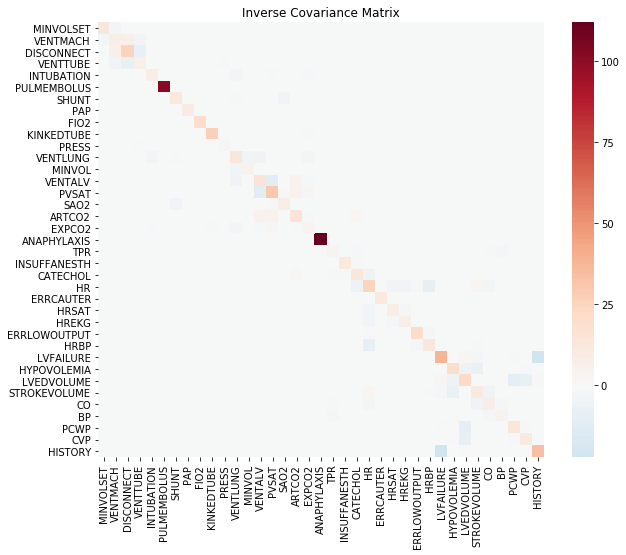

In [12]:
pf.session.visualize_inverse_covariance()

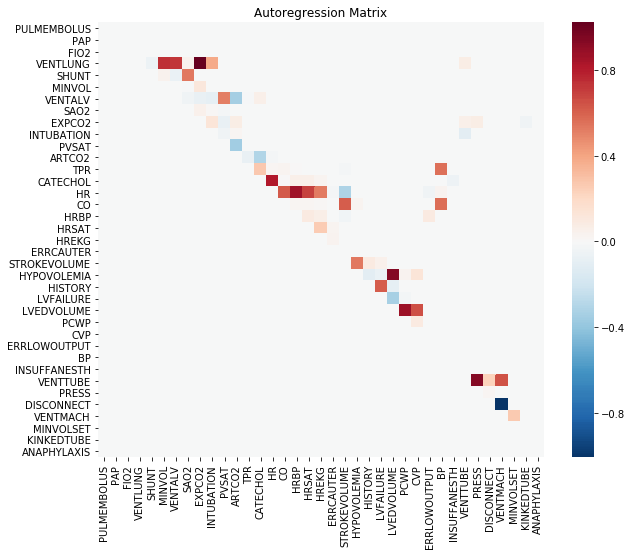

In [13]:
pf.session.visualize_autoregression()

In [14]:
pf.session.timer.get_stat()

,time_point,msg,execution_time
0,0.007228,start: Load Data,0.000000
1,0.078212,end: Load Data,0.070984
2,0.084286,start: Create Training Data,0.000000
3,0.110327,end: Create Training Data,0.026041
4,0.116868,start: Learn Structure,0.000000
5,1.521348,end: Learn Structure,1.404480
6,1.528258,start: Get Dependencies,0.000000
7,1.654922,end: Get Dependencies,0.126664
8,1.654922,total_execution_time,1.628169
